In [1]:
import pandas as pd
import yaml
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats

In [2]:
with open("config_plot.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

sns.set(**cfg["general_plotting"])

### Load data

In [3]:
df = pd.read_excel("data/data_preprocessed.xlsx")
df

,Unnamed: 0,Timestamp,country_1,city,company_field,company_name,company_type,company_size,role,degrees_2,...,edu_M.D./PharmD/D.D.S.,edu_MD,edu_MSc,edu_PhD,edu_PharmD,edu_highest,country,region,seniority,role_class
0,0,8/6/2023 13:35:24,canada,Toronto,Academia/Research/Institution,Prefer not to say,Private,200-1000,medical writer,Bachelors or Equivalent,...,0,0,0,0,0,BSc,canada,others,normal,other
1,1,4/19/2023 19:24:24,germany,Munich,Academia/Research/Institution,Max Planck Institute,Academia/College/Universities,5000+,postdoc,PhD or Equivalent,...,0,0,0,1,0,PhD,germany,europe,normal,scientist
2,2,6/22/2023 16:28:50,slovenia,Ljubljana,Academia/Research/Institution,Prefer not to say,Public,50-200,student assistant researcher,Bachelors or Equivalent,...,0,0,0,0,0,BSc,slovenia,europe,normal,scientist
3,3,6/14/2023 15:30:45,uk,Edinburgh,Academia/Research/Institution,University of Edinburgh,Academia/College/Universities,5000+,postdoc,PhD or Equivalent,...,0,0,0,1,0,PhD,uk,europe,normal,scientist
4,4,3/29/2023 2:06:32,us,Bay Area,Academia/Research/Institution,Prefer not to say,Start-up,1-50,research scientist,Masters or Equivalent,...,0,0,1,0,0,MSc,us,us,normal,scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,2023,9/29/2024 21:11:18,NaN,NaN,Big Pharmaceuticals,Prefer not to say,Public,5000+,asset exec,NaN,...,0,1,0,0,0,Other,us,us,normal,other
2024,2024,9/29/2024 22:12:46,NaN,NaN,Others,Mucommune,Start-up,1-50,scientist,NaN,...,0,0,0,0,0,BSc,us,us,normal,scientist
2025,2025,9/30/2024 5:33:54,NaN,NaN,Agriculture,Syngenta,Private,5000+,principal scientist i,NaN,...,0,0,0,1,0,PhD,uk,europe,normal,scientist
2026,2026,9/30/2024 8:01:19,NaN,NaN,Big Pharmaceuticals,Regeneron,Public,5000+,associate scientist,NaN,...,0,0,0,0,0,BSc,us,us,normal,scientist


In [4]:
df = df.loc[df.pay_annual_base < 1e6]  # remove outlier

df_eu = df.loc[df.region == "europe"]
df_us = df.loc[df.region == "us"]

print(f"Europe {df_eu.shape}")
print(f"US {df_us.shape}")

Europe (134, 46)
US (1824, 46)


### Dependence on educational level, per role

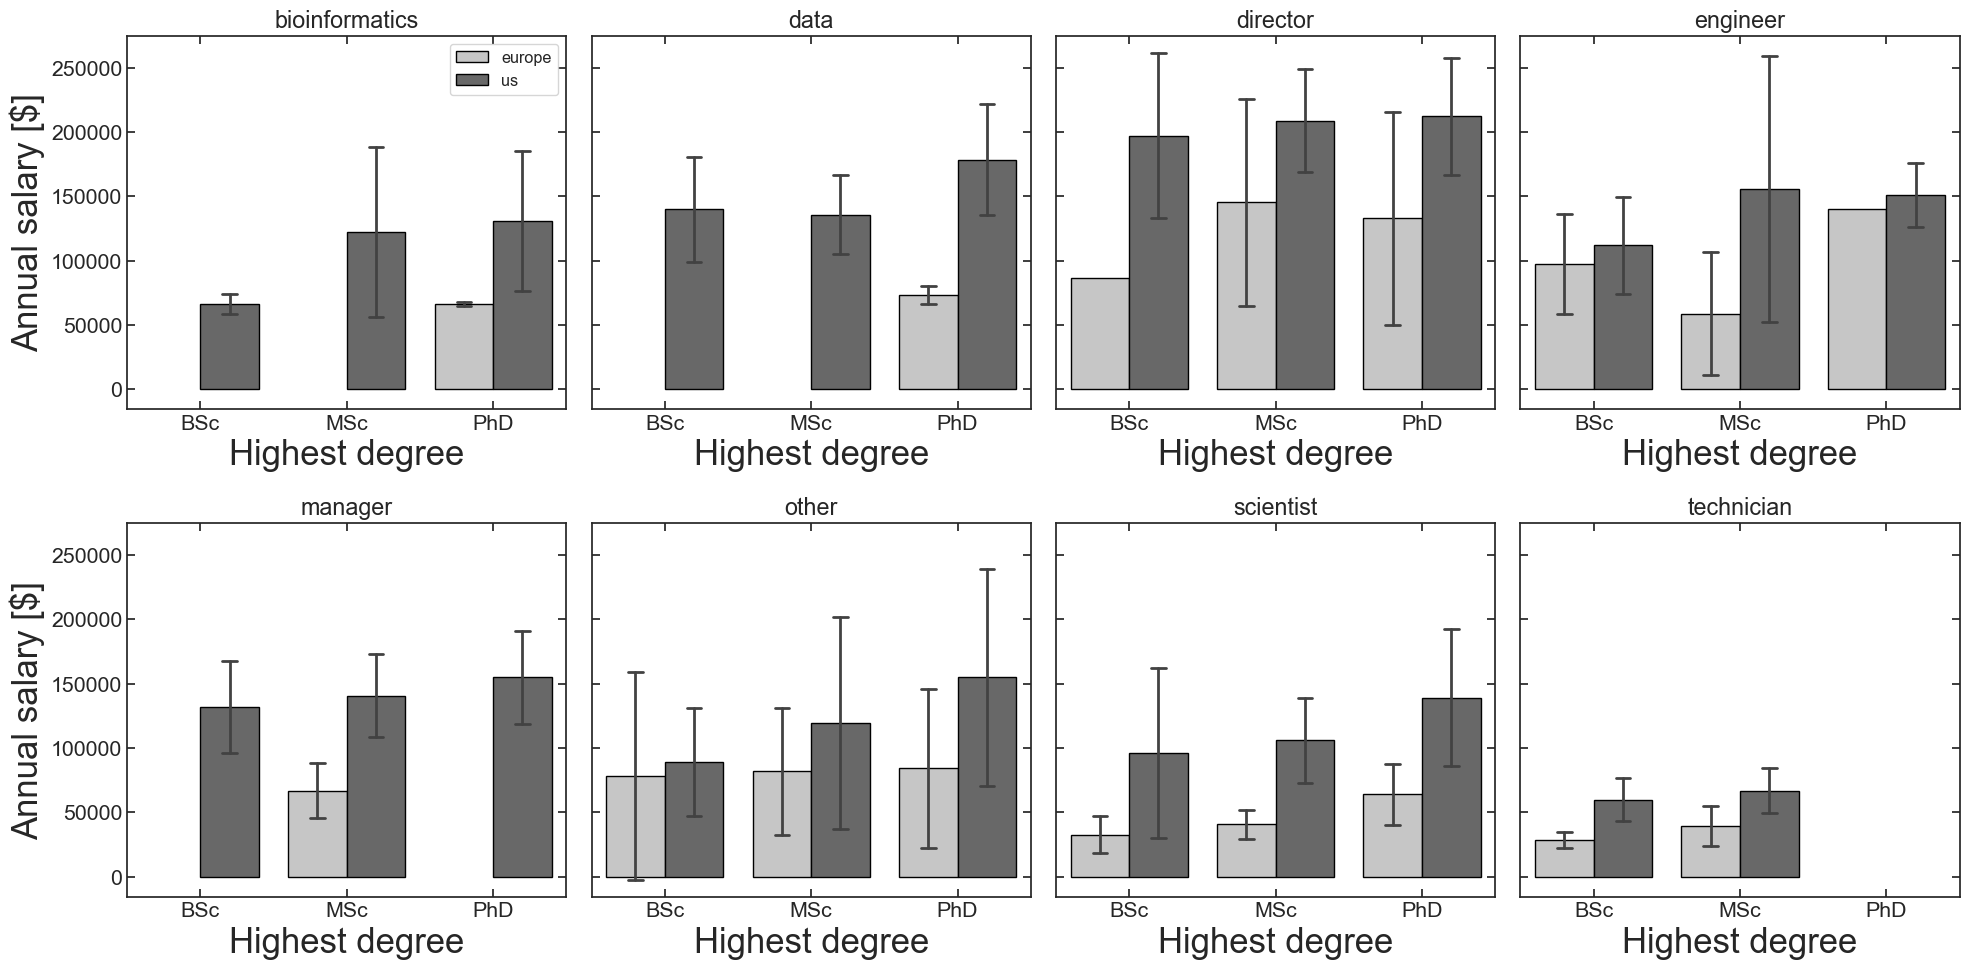

In [5]:
f, ax = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
ax = ax.reshape(-1)

for i, (g, dfg) in enumerate(df.groupby("role_class")):
    
    sns.barplot(data=dfg, x="edu_highest", y="pay_annual_base",
                hue="region",
                order=["BSc", "MSc", "PhD"],
                hue_order=["europe", "us"], 
                ax=ax[i],
                palette="Greys",
                **cfg["settings_barplots"])
    
    ax[i].set_title(g)
    ax[i].set_xlabel("Highest degree")
    ax[i].set_ylabel("")
    ax[i].legend([],[], frameon=False)

ax[0].legend()
ax[0].set_ylabel("Annual salary [$]")
ax[4].set_ylabel("Annual salary [$]")

plt.tight_layout()
plt.show()

### General differences between Europe and US

In [6]:
# Calculate mean annual salaries, per role, per educational background and per region:
df_means = df.groupby(["role_class", "edu_highest", "region"])["pay_annual_base"].mean().reset_index()

# Rearrange dataframe:
df_means = df_means.pivot_table(index=["role_class", "edu_highest"], columns="region", values="pay_annual_base")
df_means

region                             europe         others             us
role_class     edu_highest                                             
bioinformatics BSc                    NaN   42000.000000   66500.000000
               MSc                    NaN            NaN  122200.000000
               PhD           66250.000000   75000.000000  130726.666667
data           BSc                    NaN            NaN  139714.285714
               MSc                    NaN            NaN  135588.000000
               PhD           73056.000000            NaN  178555.555556
director       BSc           86300.000000  240000.000000  197167.184211
               HS                     NaN            NaN  250000.000000
               MSc          145333.333333            NaN  208591.525424
               Other                  NaN            NaN  241209.523810
               PhD          132820.000000  101000.000000  212304.692308
engineer       BSc           97500.000000   80000.000000  111734.106061
               HS                     NaN            NaN   97000.000000
               MSc           58600.000000   81000.000000  155453.571429
               Other         43225.000000            NaN   52000.000000
               PhD          140000.000000            NaN  151000.000000
manager        BSc                    NaN  111000.000000  131859.807692
               HS                     NaN            NaN  124666.666667
               MSc           66750.000000  150000.000000  140700.982456
               Other            87.000000            NaN  171071.428571
               PhD                    NaN   95500.000000  154979.310345
other          BSc           78135.142857   61720.000000   89085.469939
               HS                     NaN            NaN   74069.833333
               MSc           81826.500000   99928.571429  119152.948676
               Other        100000.000000            NaN  198877.913043
               PhD           84250.125000  201000.000000  154991.163265
scientist      BSc           32620.166667   63733.333333   96180.882736
               HS                     NaN            NaN   72600.000000
               MSc           40531.526316  155200.000000  105971.170050
               Other                  NaN            NaN  133933.333333
               PhD           63874.250000   87758.055556  139107.930476
technician     BSc           28282.500000   53000.000000   59793.090909
               HS                     NaN            NaN   75500.000000
               MSc           39156.666667            NaN   66675.000000
               Other         38400.000000            NaN   29000.000000

In [7]:
# Calculate ration US/Europe:
df_means["ratio_UsEurope"] = df_means.apply(lambda x: x["us"] / x["europe"], axis=1)
df_means

region                             europe         others             us  \
role_class     edu_highest                                                
bioinformatics BSc                    NaN   42000.000000   66500.000000   
               MSc                    NaN            NaN  122200.000000   
               PhD           66250.000000   75000.000000  130726.666667   
data           BSc                    NaN            NaN  139714.285714   
               MSc                    NaN            NaN  135588.000000   
               PhD           73056.000000            NaN  178555.555556   
director       BSc           86300.000000  240000.000000  197167.184211   
               HS                     NaN            NaN  250000.000000   
               MSc          145333.333333            NaN  208591.525424   
               Other                  NaN            NaN  241209.523810   
               PhD          132820.000000  101000.000000  212304.692308   
engineer       BSc           97500.000000   80000.000000  111734.106061   
               HS                     NaN            NaN   97000.000000   
               MSc           58600.000000   81000.000000  155453.571429   
               Other         43225.000000            NaN   52000.000000   
               PhD          140000.000000            NaN  151000.000000   
manager        BSc                    NaN  111000.000000  131859.807692   
               HS                     NaN            NaN  124666.666667   
               MSc           66750.000000  150000.000000  140700.982456   
               Other            87.000000            NaN  171071.428571   
               PhD                    NaN   95500.000000  154979.310345   
other          BSc           78135.142857   61720.000000   89085.469939   
               HS                     NaN            NaN   74069.833333   
               MSc           81826.500000   99928.571429  119152.948676   
               Other        100000.000000            NaN  198877.913043   
               PhD           84250.125000  201000.000000  154991.163265   
scientist      BSc           32620.166667   63733.333333   96180.882736   
               HS                     NaN            NaN   72600.000000   
               MSc           40531.526316  155200.000000  105971.170050   
               Other                  NaN            NaN  133933.333333   
               PhD           63874.250000   87758.055556  139107.930476   
technician     BSc           28282.500000   53000.000000   59793.090909   
               HS                     NaN            NaN   75500.000000   
               MSc           39156.666667            NaN   66675.000000   
               Other         38400.000000            NaN   29000.000000   

region                      ratio_UsEurope  
role_class     edu_highest                  
bioinformatics BSc                     NaN  
               MSc                     NaN  
               PhD                1.973233  
data           BSc                     NaN  
               MSc                     NaN  
               PhD                2.444092  
director       BSc                2.284672  
               HS                      NaN  
               MSc                1.435263  
               Other                   NaN  
               PhD                1.598439  
engineer       BSc                1.145991  
               HS                      NaN  
               MSc                2.652791  
               Other              1.203008  
               PhD                1.078571  
manager        BSc                     NaN  
               HS                      NaN  
               MSc                2.107880  
               Other           1966.338259  
               PhD                     NaN  
other          BSc                1.140146  
               HS                      NaN  
               MSc                1.456166  
               Other              1.988779  
         

In [8]:
# Remove outlier & clean dataframe:
df_means = df_means.loc[df_means.ratio_UsEurope < 100].reset_index()
df_means

region,role_class,edu_highest,europe,others,us,ratio_UsEurope
0,bioinformatics,PhD,66250.000000,75000.000000,130726.666667,1.973233
1,data,PhD,73056.000000,NaN,178555.555556,2.444092
2,director,BSc,86300.000000,240000.000000,197167.184211,2.284672
3,director,MSc,145333.333333,NaN,208591.525424,1.435263
4,director,PhD,132820.000000,101000.000000,212304.692308,1.598439
5,engineer,BSc,97500.000000,80000.000000,111734.106061,1.145991
6,engineer,MSc,58600.000000,81000.000000,155453.571429,2.652791
7,engineer,Other,43225.000000,NaN,52000.000000,1.203008
8,engineer,PhD,140000.000000,NaN,151000.000000,1.078571
9,manager,MSc,66750.000000,150000.000000,140700.982456,2.107880


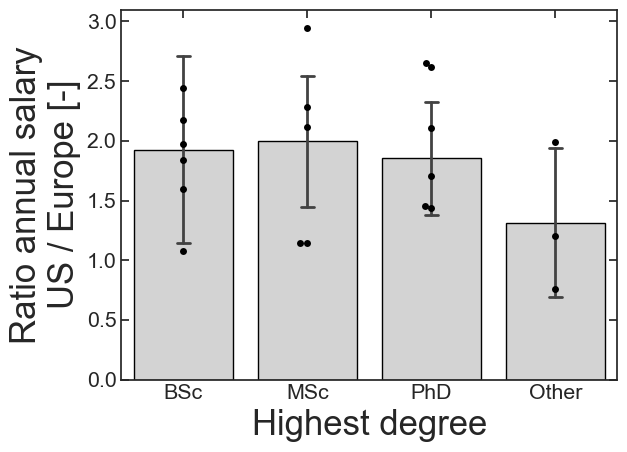

In [9]:
sns.barplot(data=df_means,
            x="edu_highest", y="ratio_UsEurope",
            order=["BSc", "MSc", "PhD", "Other"],
            **cfg["settings_barplots"]
            )
sns.swarmplot(data=df_means, x="edu_highest", y="ratio_UsEurope", color="black")

plt.xlabel("Highest degree")
plt.ylabel("Ratio annual salary\nUS / Europe [-]")

plt.show()

### Scientist positions: aggregated data

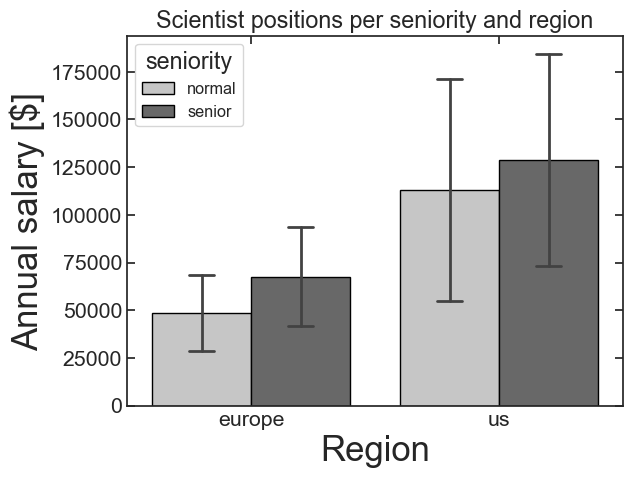

In [10]:
sns.barplot(data=df.loc[df.role_class=="scientist"],
            x="region",
            y="pay_annual_base",
            hue="seniority",
            order=["europe", "us"],
            palette="Greys",
            **cfg["settings_barplots"])
plt.title("Scientist positions per seniority and region")
plt.xlabel("Region")
plt.ylabel("Annual salary [$]")
plt.show()

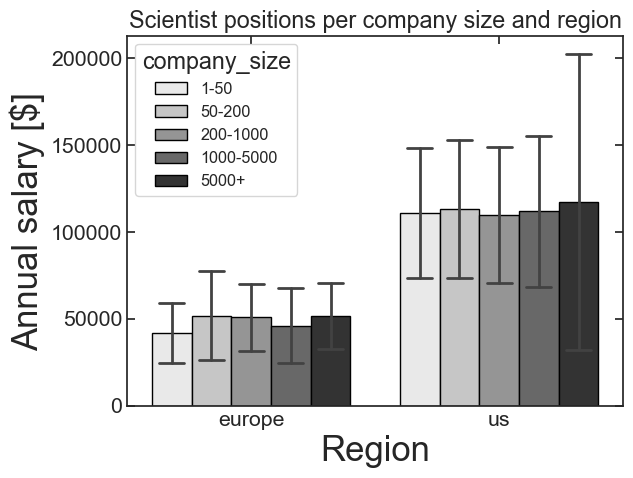

In [11]:
sns.barplot(data=df.loc[(df.role_class=="scientist") & (df.seniority=="normal")],
            x="region", y="pay_annual_base",
            order=["europe", "us"],
            hue="company_size",
            hue_order=["1-50", "50-200", "200-1000", "1000-5000", "5000+"],   
            palette="Greys",       
            **cfg["settings_barplots"]
            )

plt.title("Scientist positions per company size and region")
plt.xlabel("Region")
plt.ylabel("Annual salary [$]")
plt.show()

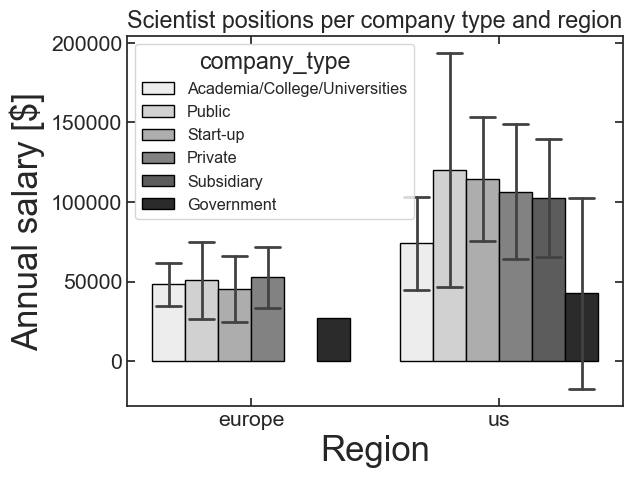

In [12]:
sns.barplot(data=df.loc[(df.role_class=="scientist") & (df.seniority=="normal")],
            x="region", y="pay_annual_base",
            order=["europe", "us"],
            hue="company_type",
            palette="Greys",       
            **cfg["settings_barplots"]
            )

plt.title("Scientist positions per company type and region")
plt.xlabel("Region")
plt.ylabel("Annual salary [$]")
plt.show()

### Scientist positions: dependence on experience 

In [13]:
# Select only "scientist" roles:
df_sci = df.loc[df.role_class == "scientist"]
df_sci.head()

,Unnamed: 0,Timestamp,country_1,city,company_field,company_name,company_type,company_size,role,degrees_2,...,edu_M.D./PharmD/D.D.S.,edu_MD,edu_MSc,edu_PhD,edu_PharmD,edu_highest,country,region,seniority,role_class
1,1,4/19/2023 19:24:24,germany,Munich,Academia/Research/Institution,Max Planck Institute,Academia/College/Universities,5000+,postdoc,PhD or Equivalent,...,0,0,0,1,0,PhD,germany,europe,normal,scientist
2,2,6/22/2023 16:28:50,slovenia,Ljubljana,Academia/Research/Institution,Prefer not to say,Public,50-200,student assistant researcher,Bachelors or Equivalent,...,0,0,0,0,0,BSc,slovenia,europe,normal,scientist
3,3,6/14/2023 15:30:45,uk,Edinburgh,Academia/Research/Institution,University of Edinburgh,Academia/College/Universities,5000+,postdoc,PhD or Equivalent,...,0,0,0,1,0,PhD,uk,europe,normal,scientist
4,4,3/29/2023 2:06:32,us,Bay Area,Academia/Research/Institution,Prefer not to say,Start-up,1-50,research scientist,Masters or Equivalent,...,0,0,1,0,0,MSc,us,us,normal,scientist
6,6,3/29/2023 16:57:27,us,Los Angeles,Academia/Research/Institution,Thermo Fisher,Public,5000+,technical application scientist ii,PhD or Equivalent,...,0,0,0,1,0,PhD,us,us,normal,scientist


In [14]:
def plot_regression(df, xvar, yvar, filter_region, filter_degree, ax):

    # Select data
    dfg = df.loc[  (df.region==filter_region)
                 & (df.edu_highest==filter_degree)
                 ][[xvar, yvar]].dropna()

    # Plot regression
    sns.regplot(data=dfg, x=xvar, y=yvar, ax=ax, label=filter_degree, scatter_kws={"alpha": 0.4})

    # Perform regression:
    X = dfg[xvar]
    X = sm.add_constant(X)
    y = dfg[yvar]
    results = sm.OLS(y, X).fit()

    return results


def retrieve_params(results: sm.regression.linear_model.OLSResults, var: str):
    x = results.params.loc[var]
    ci_low, ci_high = results.conf_int().loc[var]
    return (ci_low, x, ci_high)

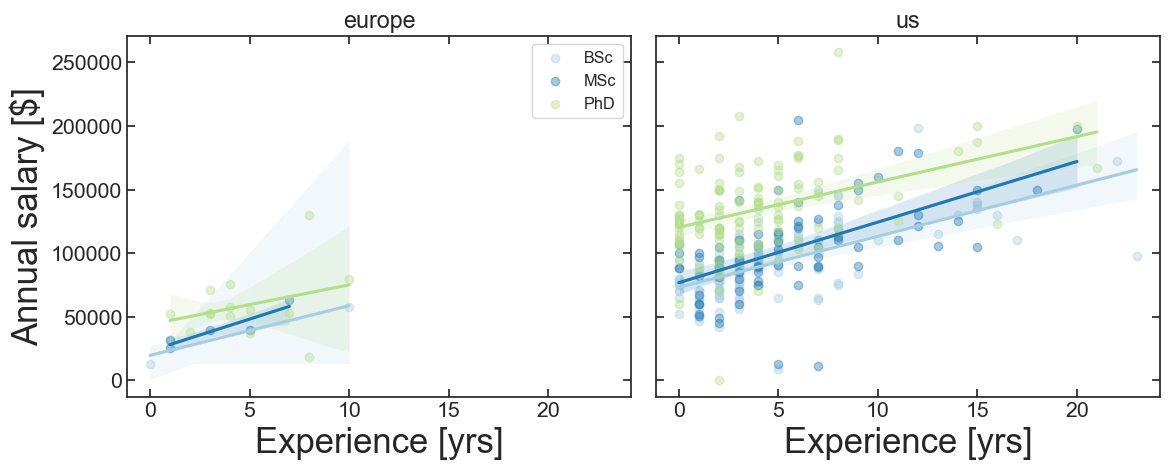

In [15]:
# Initialize dict to store regressed parameters:
stats_store = {}

f, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for g  in ["BSc", "MSc", "PhD"]:
    for i, region in enumerate(["europe", "us"]):

        # Perform regression:
        res = plot_regression(df_sci, xvar="experience_yrs", yvar="pay_annual_base", filter_region=region, filter_degree=g, ax=ax[i])
        ax[i].set_title(region)
    
        # Stored regressed parameters:
        c_lo, c, c_hi = retrieve_params(res, "const")
        m_lo, m, m_hi = retrieve_params(res, "experience_yrs")
        stats_store[(region, g)] = {"intercept_low": c_lo, "intercept": c, "intercept_high": c_hi,
                                    "slope_low": m_lo, "slope": m, "slope_high": m_hi}

        ax[i].set_ylabel("")
        ax[i].set_xlabel("Experience [yrs]")
ax[0].legend()
ax[0].set_ylabel("Annual salary [$]")

plt.tight_layout()
plt.show()

In [16]:
# Store regression parameters in dataframe:
df_regression = pd.DataFrame(stats_store).T.reset_index()
df_regression.rename(columns={"level_0": "region",
                              "level_1": "edu_highest"}, inplace=True)
df_regression

,region,edu_highest,intercept_low,intercept,intercept_high,slope_low,slope,slope_high
0,europe,BSc,-71946.698360,19619.593407,111185.885173,-11871.290800,3909.747253,19690.785305
1,us,BSc,67961.912715,73117.644597,78273.376479,3179.144892,4018.954322,4858.763753
2,europe,MSc,7660.294315,23150.000000,38639.705685,1246.135727,5002.941176,8759.746626
3,us,MSc,65490.232611,76790.844106,88091.455602,3178.192104,4763.498099,6348.804093
4,europe,PhD,11554.149808,44021.776675,76489.403542,-2916.434960,3105.240695,9126.916350
5,us,PhD,112642.428160,120292.872474,127943.316788,2174.632835,3569.918964,4965.205094


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10328\4158173948.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=dfg,
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10328\4158173948.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=dfg,


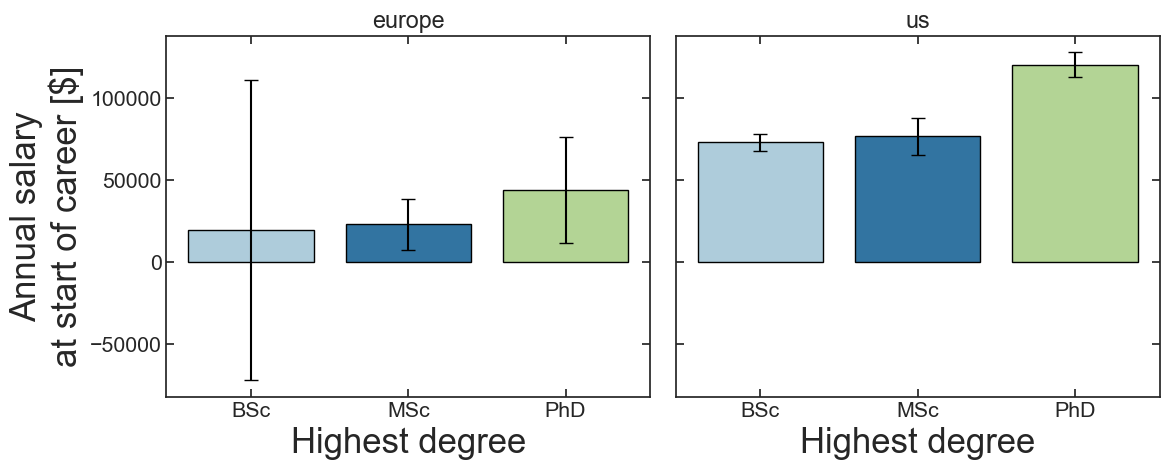

In [17]:
f, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for i, (g, dfg) in enumerate(df_regression.groupby("region")):
    
      # Display value of the slope
      sns.barplot(data=dfg,
                  x="edu_highest", y="intercept",
                  ci=None,
                  ax=ax[i], 
                  edgecolor="black")

      # Add error bars (95% c.i. of the slope)
      ax[i].errorbar(x=dfg["edu_highest"],
                     y=dfg["intercept"],
                     yerr=[dfg["intercept"] - dfg["intercept_low"],
                           dfg["intercept_high"] - dfg["intercept"]],
                     fmt="None",
                     color="black",
                     capsize=5
                     )
      
      ax[i].set_title(g)
      ax[i].set_xlabel("Highest degree")
      ax[i].set_ylabel("")
ax[0].set_ylabel("Annual salary\nat start of career [$]")

plt.tight_layout()
plt.show()

### Highest degree and chances of reaching higher roles

In [18]:
# Counts per role and seniority level:
df_progression = df.groupby(["role_class", "seniority", "edu_highest"]).count()["Timestamp"].to_frame()   # "region", 
df_progression

Timestamp
role_class     seniority edu_highest           
bioinformatics normal    BSc                  3
                         MSc                  3
                         PhD                  7
               senior    PhD                  2
data           normal    BSc                  4
...                                         ...
technician     normal    HS                   1
                         MSc                  4
                         Other                3
               senior    BSc                  1
                         MSc                  1

[62 rows x 1 columns]

In [19]:
df_fractions = df_progression.reset_index().pivot_table(columns="edu_highest", index=["role_class", "seniority"], values="Timestamp")

education_cols = ["BSc", "HS", "MSc", "Other", "PhD"]

df_fractions["fraction_BSc"] = df_fractions["BSc"] / df_fractions[education_cols].sum(axis=1)
df_fractions["fraction_MSc"] = df_fractions["MSc"] / df_fractions[education_cols].sum(axis=1)
df_fractions["fraction_PhD"] = df_fractions["PhD"] / df_fractions[education_cols].sum(axis=1)

df_fractions

edu_highest                 BSc   HS    MSc  Other    PhD  fraction_BSc  \
role_class     seniority                                                  
bioinformatics normal       3.0  NaN    3.0    NaN    7.0      0.230769   
               senior       NaN  NaN    NaN    NaN    2.0           NaN   
data           normal       4.0  NaN    5.0    NaN    3.0      0.333333   
               senior       3.0  NaN    4.0    NaN    8.0      0.200000   
director       normal      33.0  1.0   52.0   18.0  116.0      0.150000   
               senior       7.0  NaN   13.0    3.0   20.0      0.162791   
engineer       normal      53.0  1.0   21.0    2.0    4.0      0.654321   
               senior      16.0  NaN   14.0    NaN    6.0      0.444444   
manager        normal      56.0  2.0   40.0    4.0   18.0      0.466667   
               senior      24.0  1.0   22.0    4.0   13.0      0.375000   
other          normal     151.0  4.0   66.0   16.0   56.0      0.515358   
               senior      29.0  2.0   16.0    8.0    4.0      0.491525   
scientist      normal     249.0  3.0  160.0    4.0  318.0      0.339237   
               senior      73.0  NaN   69.0    2.0  168.0      0.233974   
technician     normal      13.0  1.0    4.0    3.0    NaN      0.619048   
               senior       1.0  NaN    1.0    NaN    NaN      0.500000   

edu_highest               fraction_MSc  fraction_PhD  
role_class     seniority                              
bioinformatics normal         0.230769      0.538462  
               senior              NaN      1.000000  
data           normal         0.416667      0.250000  
               senior         0.266667      0.533333  
director       normal         0.236364      0.527273  
               senior         0.302326      0.465116  
engineer       normal         0.259259      0.049383  
               senior         0.388889      0.166667  
manager        normal         0.333333      0.150000  
               senior         0.343750      0.203125  
other          normal         0.225256      0.191126  
               senior         0.271186      0.067797  
scientist      normal         0.217984      0.433243  
               senior         0.221154      0.538462  
technician     normal         0.190476           NaN  
               senior         0.500000           NaN

In [20]:
df_fractions_rearranged = df_fractions.copy().reset_index()
df_fractions_rearranged = df_fractions_rearranged.pivot_table( #columns=["seniority"],
                                                              index=["seniority", "role_class", ],
                                                              values=["fraction_PhD", "fraction_MSc", "fraction_BSc"]
                                                              )
df_fractions_rearranged

edu_highest               fraction_BSc  fraction_MSc  fraction_PhD
seniority role_class                                              
normal    bioinformatics      0.230769      0.230769      0.538462
          data                0.333333      0.416667      0.250000
          director            0.150000      0.236364      0.527273
          engineer            0.654321      0.259259      0.049383
          manager             0.466667      0.333333      0.150000
          other               0.515358      0.225256      0.191126
          scientist           0.339237      0.217984      0.433243
          technician          0.619048      0.190476           NaN
senior    bioinformatics           NaN           NaN      1.000000
          data                0.200000      0.266667      0.533333
          director            0.162791      0.302326      0.465116
          engineer            0.444444      0.388889      0.166667
          manager             0.375000      0.343750      0.203125
          other               0.491525      0.271186      0.067797
          scientist           0.233974      0.221154      0.538462
          technician          0.500000      0.500000           NaN

In [21]:
# Sanity check: values <= 1.0
df_fractions_rearranged.sum(axis=1)

seniority  role_class    
normal     bioinformatics    1.000000
           data              1.000000
           director          0.913636
           engineer          0.962963
           manager           0.950000
           other             0.931741
           scientist         0.990463
           technician        0.809524
senior     bioinformatics    1.000000
           data              1.000000
           director          0.930233
           engineer          1.000000
           manager           0.921875
           other             0.830508
           scientist         0.993590
           technician        1.000000
dtype: float64

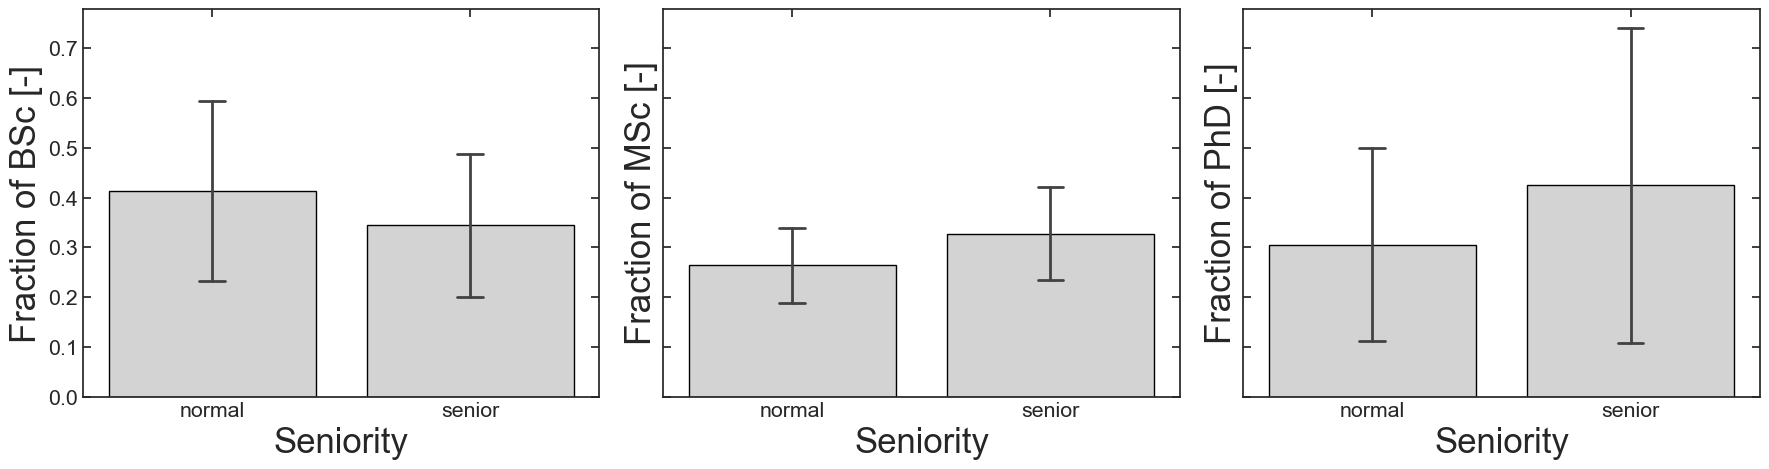

In [22]:
f, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for  i, degree in enumerate(["BSc", "MSc", "PhD"]):

    sns.barplot(data=df_fractions_rearranged.reset_index(),
                x="seniority", y=f"fraction_{degree}",
                ax=ax[i],
                **cfg["settings_barplots"])
    
    ax[i].set_xlabel("Seniority")
    ax[i].set_ylabel(f"Fraction of {degree} [-]")

plt.tight_layout()
plt.show()

##### Enrichment analysis

In [23]:
df_ = df_progression.reset_index()
df_.rename(columns={"Timestamp": "counts"}, inplace=True)
df_

,role_class,seniority,edu_highest,counts
0,bioinformatics,normal,BSc,3
1,bioinformatics,normal,MSc,3
2,bioinformatics,normal,PhD,7
3,bioinformatics,senior,PhD,2
4,data,normal,BSc,4
...,...,...,...,...
57,technician,normal,HS,1
58,technician,normal,MSc,4
59,technician,normal,Other,3
60,technician,senior,BSc,1


In [24]:
# Initialize datafrma to store values:
df_enrichment = pd.DataFrame({})


for g, dfg in df_.groupby("role_class"):

    # All roles:
    N = dfg["counts"].sum()

    Mj = dfg.loc[ (dfg["edu_highest"]=="PhD"), "counts"].sum()
    
    f_1 = Mj / N  # fraction of PhDs

    # Senior-roles only:
    n = dfg.loc[ (dfg["seniority"]=="senior"), "counts"].sum()

    kj = dfg.loc[  (dfg["seniority"]=="senior")
                 & (dfg["edu_highest"]=="PhD"), "counts"].sum()
    
    f_2 = kj / n  # fraction of PhDs in senior positions

    # Perform hypergeometric test:
    p_j = 1 - stats.hypergeom.cdf(kj, N, Mj, n)
    
    # Store values:
    df_i = pd.DataFrame({"role": g, 
                         "n_total": N,
                         "n_total_PhD": Mj,
                         "f_total_PhD": f_1,
                         "n_senior": n,
                         "n_senior_PhD": kj,
                         "f_senior_PhD": f_2,
                         "p_value": p_j}, index=[0])
    df_enrichment = pd.concat([df_enrichment, df_i], ignore_index=True)

    # Display values:
    print(f">> Role: {g}")
    print("")
    print(f"Total no.: {N}")
    print(f"... of which holding PhD: {Mj}\n")
    print(f"No. senior positions: {n}")
    print(f"... of which holding PhD: {kj}")
    print("")
    print(f"p = {p_j :.3}\n")

>> Role: bioinformatics

Total no.: 15
... of which holding PhD: 9

No. senior positions: 2
... of which holding PhD: 2

p = 0.0

>> Role: data

Total no.: 27
... of which holding PhD: 11

No. senior positions: 15
... of which holding PhD: 8

p = 0.0282

>> Role: director

Total no.: 263
... of which holding PhD: 136

No. senior positions: 43
... of which holding PhD: 20

p = 0.719

>> Role: engineer

Total no.: 117
... of which holding PhD: 10

No. senior positions: 36
... of which holding PhD: 6

p = 0.00917

>> Role: manager

Total no.: 184
... of which holding PhD: 31

No. senior positions: 64
... of which holding PhD: 13

p = 0.131

>> Role: other

Total no.: 352
... of which holding PhD: 60

No. senior positions: 59
... of which holding PhD: 4

p = 0.988

>> Role: scientist

Total no.: 1046
... of which holding PhD: 486

No. senior positions: 312
... of which holding PhD: 168

p = 0.000717

>> Role: technician

Total no.: 23
... of which holding PhD: 0

No. senior positions: 2
..

In [25]:
# Determined additonal values:

## Fold change/enrichment factor:
df_enrichment["foldChange"] = df_enrichment["f_senior_PhD"] / df_enrichment["f_total_PhD"]
df_enrichment["log2_foldChange"] = np.log2(df_enrichment["foldChange"])

## False discovery rate (for multiple comparisons)
df_enrichment["fdr"] = stats.false_discovery_control(df_enrichment["p_value"])
df_enrichment["-log10_fdr"] = -np.log10(df_enrichment["fdr"])

df_enrichment.replace(np.inf, np.nan, inplace=True)
df_enrichment

c:\Users\Utilizador\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,role,n_total,n_total_PhD,f_total_PhD,n_senior,n_senior_PhD,f_senior_PhD,p_value,foldChange,log2_foldChange,fdr,-log10_fdr
0,bioinformatics,15,9,0.600000,2,2,1.000000,0.000000,1.666667,0.736966,0.000000,NaN
1,data,27,11,0.407407,15,8,0.533333,0.028205,1.309091,0.388565,0.045128,1.345557
2,director,263,136,0.517110,43,20,0.465116,0.718864,0.899453,-0.152881,0.821559,0.085361
3,engineer,117,10,0.085470,36,6,0.166667,0.009172,1.950000,0.963474,0.018345,1.736484
4,manager,184,31,0.168478,64,13,0.203125,0.131123,1.205645,0.269805,0.174831,0.757382
5,other,352,60,0.170455,59,4,0.067797,0.987657,0.397740,-1.330102,0.987657,0.005394
6,scientist,1046,486,0.464627,312,168,0.538462,0.000717,1.158911,0.212770,0.001913,2.718298
7,technician,23,0,0.000000,2,0,0.000000,0.000000,NaN,NaN,0.000000,NaN


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10328\3918019662.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


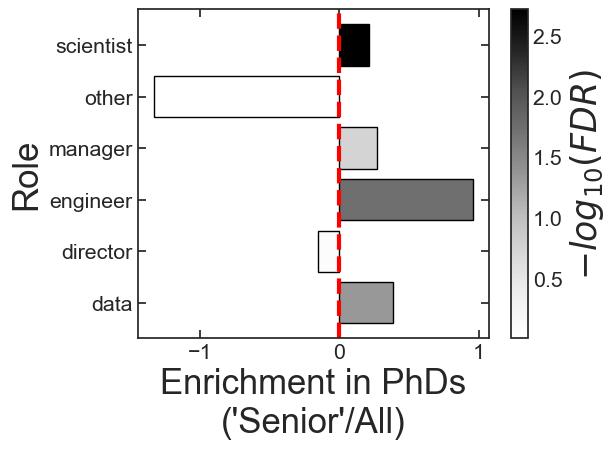

In [26]:
# Remove rows with NaNs:
dff = df_enrichment.dropna()

# Get scale of FDR values (for colorbar):
values = dff["-log10_fdr"].values
norm = plt.Normalize(min(values), max(values))
cmap = plt.cm.Greys
colors = cmap(norm(values))

# Display enrichment factors:
plt.barh(y=dff["role"],
         width=dff["log2_foldChange"],
         color=colors,
         edgecolor="black",)

# Display colorbar:
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label(r"$-log_{10}(FDR)$")

# Add reference line: 
plt.axvline(0, color="red", linestyle="--", linewidth=3)

plt.ylabel("Role")
plt.xlabel("Enrichment in PhDs\n('Senior'/All)")
plt.tight_layout()
plt.show()

### Look into individual roles

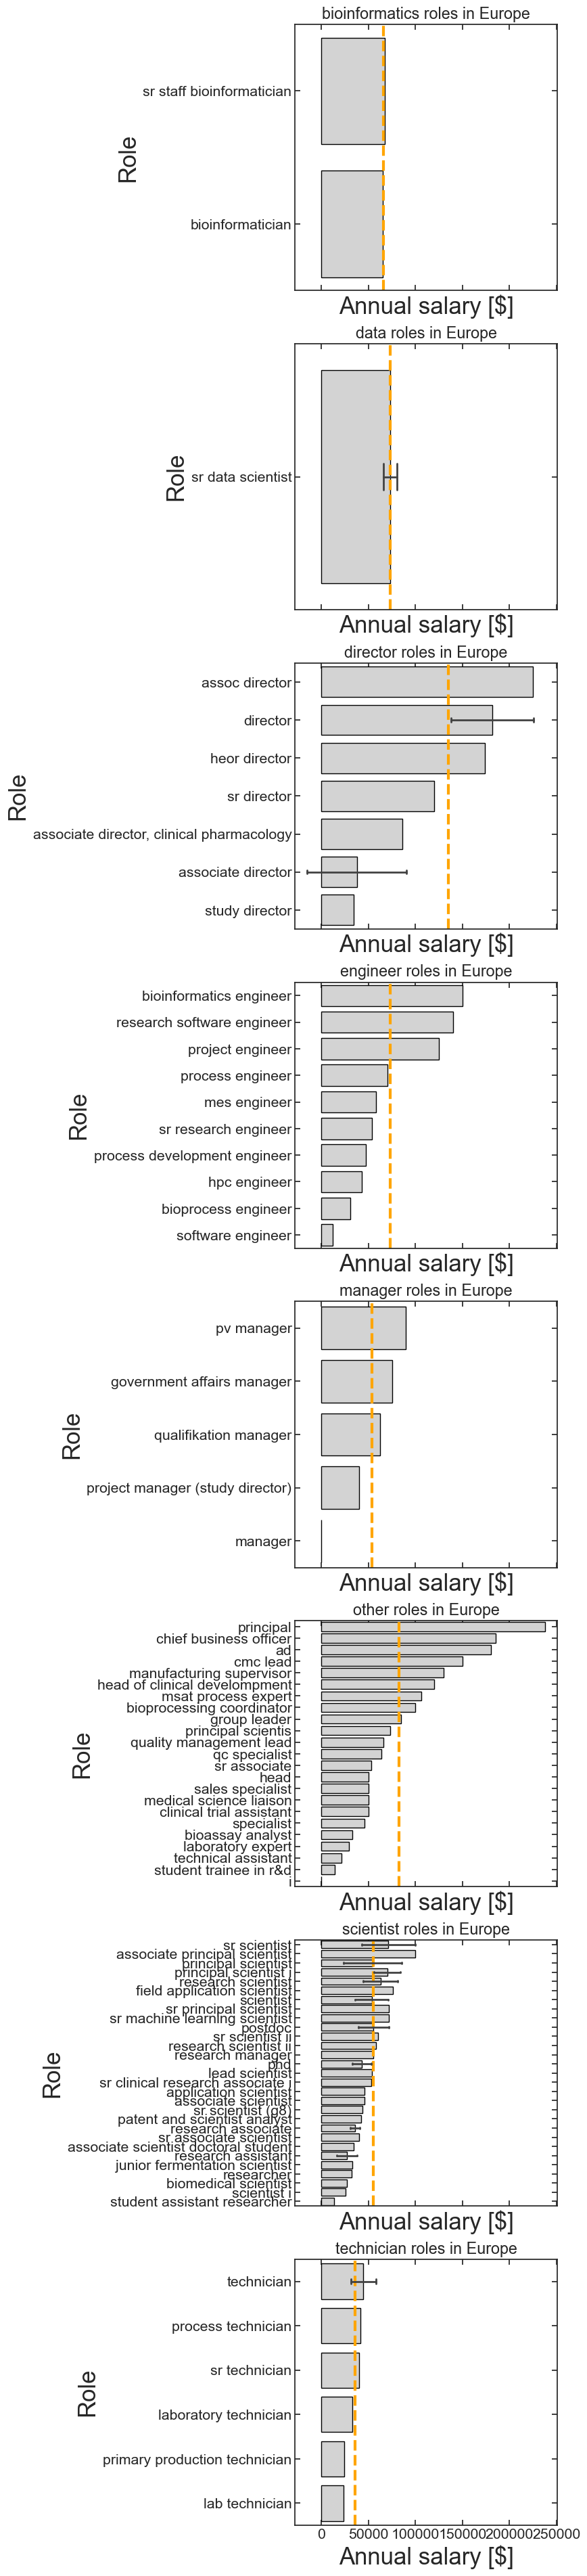

In [27]:
f, ax = plt.subplots( len(df_eu.role_class.unique()), 1,
                      figsize=(5, 6*len(df_eu.role_class.unique())),
                      sharex=True)

for i, (g, dfg) in enumerate(df_eu.groupby("role_class")):

    # display(dfg.head())
    mean = dfg["pay_annual_base"].mean()
    ax[i].axvline(mean, color="orange", linestyle="--", linewidth=3)

    sns.barplot(data=dfg.sort_values(by="pay_annual_base", ascending=False),
                y="role",
                x="pay_annual_base",
                ax=ax[i],
                **cfg["settings_barplots"])
    


    ax[i].set_title(f"{g} roles in Europe")
    ax[i].set_ylabel("Role")
    ax[i].set_xlabel("Annual salary [$]")
plt.show()